<a href="https://colab.research.google.com/github/penguin1109/BOAZ_BASE_2021/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import torch

!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"beasterea1109","key":"279cae26f5489744999fb4892f9b1c35"}'}

In [2]:
# json 파일 옮겨주기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c bike-sharing-demand

  0% 0.00/140k [00:00<?, ?B/s]
100% 140k/140k [00:00<00:00, 53.0MB/s]
  0% 0.00/316k [00:00<?, ?B/s]
100% 316k/316k [00:00<00:00, 90.7MB/s]
  0% 0.00/633k [00:00<?, ?B/s]
100% 633k/633k [00:00<00:00, 87.5MB/s]


In [5]:
# 다운로드 된 것들 다 보기 
!ls
# 필요하면 압축 풀기 
!unzip train.zip

kaggle.json  sample_data  sampleSubmission.csv	test.csv  train.csv
unzip:  cannot find or open train.zip, train.zip.zip or train.zip.ZIP.


In [6]:
import pandas as pd

bike_df = pd.read_csv('/content/train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


- 데이터형을 살펴보면 'datatime' column만 object의 형태이다.
- 이는 보면 '년 - 월 - 일 - 시:분:초'의 문자 형식으로 이루어져 있기 때문에 이에 대한 가공이 필요하다.
- pandas에서는 datetime과 같은 문자열을 년도, 월, 일 시간, 분, 초로 편리하게 분리하기 위해서 문자열을 'datetime' 타입으로 변경해야 한다.
  - 이를 위해 ```apply(pd.to_datetime)```메서드를 사용한다.

In [8]:
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

bike_df['year'] = bike_df.datetime.apply(lambda x: x.year)
bike_df['month']  = bike_df.datetime.apply(lambda x: x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x: x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [9]:
# bike_df['datetime'] column은 이제 불필요한 정보이기 때문에 없애준다
drop_columns = ['datetime', 'casual', 'registered']
# casual + registered = count인데 casual, registered 변수는 오히려 count와의 높은 상관도로 인해 예측을 저해할 우려가 존재한다. (공분산성의 문제 - 회귀문제에서 제일 심각한 문제이다.)
# 따라서 해당 변수는 지워주는 것이 중요하다.
bike_df.drop(drop_columns, axis = 1, inplace = True)

In [10]:
# Root Mean Squared Log Error인 RMSLE를 사용해서 오류값의 로그를 구한다. (물론 sklearn에서 지원하는 기능은 따로 없다.)
from sklearn.metrics import mean_squared_error, mean_absolute_error
# loss값에 NAN이 있을 것을 대비해서 log()가 아니라 log1p() 함수를 사용하는데, 이는 1 + log()의 값을 반환하기 때문에 underflow / overflow와 같은 문제를 해결해 준다.
def rmsle(y_pred, y):
  log_y = np.log1p(y_pred)
  log_pred = np.log1p(y)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

def rmse(y_pred, y):
  return np.sqrt(mean_squared_error(y, y_pred))

def evaluate_regr(y_pred, y):
  val_rmsle = rmsle(y_pred, y)
  val_rmse = rmse(y_pred, y)
  val_mae = mean_absolute_error(y, y_pred)
  print('RMSLE : {0:.3f}, RMSE : {1:.3F}, MAE : {2:.3F}'.format(val_rmsle, val_rmse, val_mae))


In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
# 순서대로 단순 선형 회귀, L1 규제를 이용한 Lasso 회귀, L2 규제를 이용한 Ridge 회귀이다.
from sklearn.linear_model import LinearRegression, Lasso, Ridge

y_target = bike_df['count']
x_features = bike_df.drop(['count'], axis = 1, inplace = False)

x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size = 0.3, random_state = 0)

Lin_reg = LinearRegression()
Lin_reg.fit(x_train, y_train)
prediction = Lin_reg.predict(x_test)

evaluate_regr(prediction, y_test)




RMSLE : 1.165, RMSE : 140.900, MAE : 105.924


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """


In [12]:
# 실제 값과 예측값의 차이를 알아보기 위해서 DataFrame의 칼럼으로 만들어서 오류 값이 가장 큰 순으로 5개만 확인해 보고자 한다
def get_top_error_data(prediction, y_test, n_tops = 5):
  result_df = pd.DataFrame(y_test.values, columns = ['real count'])
  result_df['predicted count'] = np.round(prediction)
  # 실제 값과 예측값의 잔차를 구해서 diff 칼럼으로 저장
  result_df['diff'] = np.abs(result_df['real count'] - result_df['predicted count'])
  # 내림차순으로 diff 칼럼을 정렬
  print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(prediction, y_test, n_tops = 5)


      real count  predicted count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


**Regression분석에서 이렇게 큰 예측 오류가 발생하는 경우에는 가장 먼저 살펴볼 것은 Target값의 분포가 왜곡된 형태를 이루고 있는지 아닌지이다. Target값의 분포는 정규 분포의 형태가 제일 좋다. 그렇지 않고서는 회귀 예측의 성능이 저하되는 경우가 발생하기 쉽기 때문이다.**

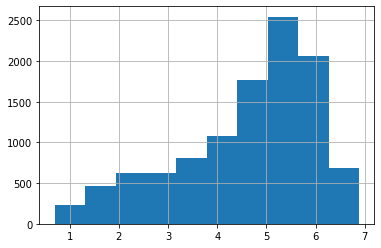

In [13]:
# log 변환을 적용한 target
y_log_trans = np.log1p(y_target)
y_log_trans.hist()

In [14]:
y_target_log = np.log1p(y_target)
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target_log, test_size = 0.3, random_state = 0)
Lin_reg = LinearRegression()
Lin_reg.fit(x_train, y_train)
prediction = Lin_reg.predict(x_test)
y_test_exp = np.expm1(y_test)
prediction_exp = np.expm1(prediction)
evaluate_regr(prediction_exp, y_test_exp)



RMSLE : 1.017, RMSE : 162.594, MAE : 109.286


1. RMSLE = ((log(y)-log(y_pred))^2)의 평균의 루트 씌운 값
2. RMSE = (y - y_pred)^2의 평균에 루트 씌운 값   
이러한데 target에 log를 붙여서 정규화한 이후에 RMSLE는 감소한 반면 RMSE는 증가한 경향을 확인할 수 있다.
- 이러한 상황이 발생한 이유를 **각 feature의 회귀 계수 값**을 시각화해 봄으로서 알아보자

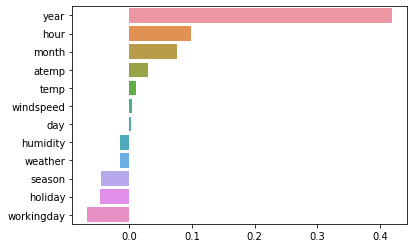

In [15]:
import seaborn as sns
coef = pd.Series(Lin_reg.coef_, index = x_features.columns)
coef_sort = coef.sort_values(ascending= False)
sns.barplot(x = coef_sort, y=coef_sort.index)

- 살펴보니 'year'의 데이터를 담는 column의 회귀계수 값이 너무 크다. 원래 해당 데이터는 object의 형태였는데 수치형 데이터로 바꾸어 준 것이기 때문에 이 숫자값에 크게 영향을 받는 경우가 나타날 수있다.(sklearn의 경우에는 수치형 데이터만 적용이 가능)
- 따라서 이러한 feature에는 one-hot encoding을 적용해 주어야 한다.
- pandas의 get_dummies()를 이용해서 모든 column을 one-hot encoding을 적용해보자.

In [16]:
x_train, x_test, y_train, y_test = train_test_split(pd.get_dummies(x_features, columns = ['year', 'month', 'day', 'hour', 'holiday',
                                                                                          'workingday', 'season', 'weather']), y_target_log, test_size = 0.3, random_state = 0)
x_features_onehot = pd.get_dummies(x_features, columns = ['year', 'month', 'day', 'hour', 'holiday','workingday', 'season', 'weather'])
def get_model_predict(model, x_train, x_test, y_train, y_test, is_expm1 = False):
  model.fit(x_train, y_train)
  prediction = model.predict(x_test)
  if is_expm1:
    y_test = np.expm1(y_test)
    prediction = np.expm1(prediction)
  print('\n###', model.__class__.__name__,'###')
  evaluate_regr(y_test, prediction)

Lin_reg = LinearRegression()
Lasso_reg = Lasso(alpha = 0.01)
Ridge_reg = Ridge(alpha = 10)

for model in [Lin_reg, Lasso_reg, Ridge_reg]:
  get_model_predict(model, x_train, x_test, y_train, y_test, is_expm1 = True)




### LinearRegression ###
RMSLE : 0.590, RMSE : 97.688, MAE : 63.382

### Lasso ###
RMSLE : 0.635, RMSE : 113.219, MAE : 72.803

### Ridge ###
RMSLE : 0.590, RMSE : 98.529, MAE : 63.893


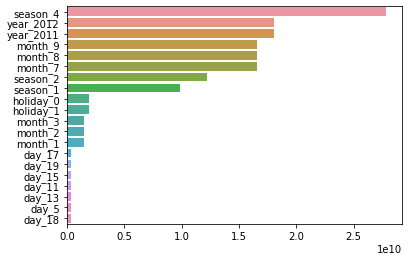

In [17]:
coef = pd.Series(Lin_reg.coef_, index = x_features_onehot.columns)
coef_sort = coef.sort_values(ascending = False)[:20]
sns.barplot(x = coef_sort.values, y = coef_sort.index)



```
def __init__(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1,  
  n_estimators=100, subsample_for_bin=200000, objective=None,    
  class_weight=None, min_split_gain=0.0, min_child_weight=0.001, 
  min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, 
  reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, 
  importance_type='split', **kwargs)
```
- 아래 사용한 Regressor들을 살펴보면 모두 **회귀 트리**이다.
1. Random Forest Regressor
  - 계속해서 root node로부터 각각의 feature에 맞게 자식 노드를 생성해 가며 계속해서 분류를 해 나간다.

2. Gradient Boost Regressor
  - 여러개의 약한 학습기를 순차적으로 학습-예측하며 잘못 예측한 데이터에 가중치를 부여해 오류를 개선해 나가며 학습하는 방식
  - Ada Boost 처럼 **오류데이터에 가중치를 부여**하지만 가중치를 업데이트 할 때에 경사 하강법을 사용한다.
  - 경사하강법을 사용한다는 것은 각각의 (실제-예측)을 계산한 오류식을 최소화하는 방향성을 가지고 지속적으로 가중치 값을 업데이트 하는 것이다.

3. XGB Regressor
  - Gradient Boost Regressor이 시간이 너무 오래 걸린다는 문제와 Regression을 적용할 수 없다는 것에 있어서 차이점이 존재 (성능 UP)
  - 마찬가지로 트리 기반의 앙상블

4. LGBM Regressor
  - XGB Regressor도 여전히 시간이 오래 걸리는데, 이 문제를 해결하기 위해 균형 트리 분할이 아닌 리프 중심 트리 분할을 사용해서 이를 개선한다.(그래서 Light라는 수식어가 앞에 붙음)
  - 트리의 균형을 맞추는 데에 집중을 하기 보다는 최소손실값을 가지는 leaf node만을 지속적으로 분할한다.





In [18]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

RF_reg = RandomForestRegressor(n_estimators = 500)
GB_reg = GradientBoostingRegressor(n_estimators = 500)
XGB_reg = XGBRegressor(n_estimators = 500)
LGBM_reg = LGBMRegressor(n_estimators = 500)

for model in [RF_reg, GB_reg, XGB_reg, LGBM_reg]:
  # XGBoost의 경우에는 DataFrame의 형태로 입력이 될 경우에 오류가 발생할 수 있으니 .values 모듈을 이용해서 ndarray의 형태로 바꾸어 입력하는 것이 안전하다.
  get_model_predict(model, x_train.values, x_test.values, y_train.values, y_test.values, is_expm1 = True)



### RandomForestRegressor ###
RMSLE : 0.354, RMSE : 50.305, MAE : 31.161

### GradientBoostingRegressor ###
RMSLE : 0.330, RMSE : 53.349, MAE : 32.748
[01:33:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

### XGBRegressor ###
RMSLE : 0.345, RMSE : 58.245, MAE : 35.768

### LGBMRegressor ###
RMSLE : 0.319, RMSE : 47.215, MAE : 29.029


In [7]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

data_description.txt: Skipping, found more recently modified local copy (use --force to force download)
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 60.6MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 31.2MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 83.6MB/s]


### House Price Kaggle High Level Analysis

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
house_df = pd.read_csv('/content/train.csv')
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


**회귀 모델을 적용하기 전에 확인해 주어야 하는 요인들**  
1. 데이터의 자료형의 종류와 그 개수
2. 데이터에 NULL값이 존재하는지, 존재한다면 각 feature별로 몇개가 존재하는지
  - 이는 drop할 column을 선택하기 위함이다.
3. target값의 분포도가 정규분포인지 확인

In [10]:
#`1. 
print('Shape: ', house_df.shape)
print('\n')
print('Feature Type:\n ', house_df.dtypes.value_counts())
print('\n')
# 2.
isnull_series = house_df.isnull().sum()
print('Null Columns:\n',(isnull_series[isnull_series > 0]).sort_values(ascending = False))

Shape:  (1460, 81)


Feature Type:
  object     43
int64      35
float64     3
dtype: int64


Null Columns:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


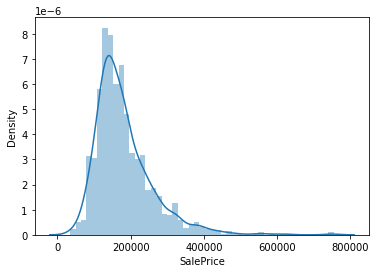

In [11]:
sns.distplot(house_df['SalePrice'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


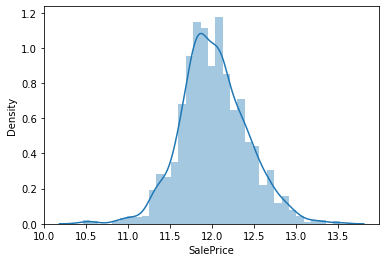

In [12]:
# 데이터의 형태가 왼쪽으로 치우쳐진, 즉 데이터 값의 분포가 중심에서 왼쪽으로 치우친 정규 분포에서 벗어나 있는 형태이기 때문에 Log Transformation을 통해서 정규 분포의 형태로 변환해 줄 수 있다.
log_saleprice = np.log1p(house_df['SalePrice'])
sns.distplot(log_saleprice)                  

In [13]:
original_Saleprice = house_df['SalePrice']
log_Saleprice = np.log1p(original_Saleprice)
house_df['SalePrice'] = log_Saleprice

house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis = 1, inplace = True)
house_df.fillna(house_df.mean(), inplace = True)

In [14]:
house_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,12.247699
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,12.109016
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,12.317171


In [15]:
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('Feature : \n', house_df.dtypes[null_column_count.index])


Feature : 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [16]:
# Null 값이 존재하는 데이터는 모두 object의 형태이기 때문에 이를 pd.get_dummies()를 이용해서 one-hot encoding을 진행해서 수치형 데이터로 바꾸어 준다.
# 이를 이용할 때에 Null 값은 None으로 바꾸어 주기 때문에 결과적으로 Null값은 존재하지 않게 될 것이다.

house_df_onehot = pd.get_dummies(house_df)

In [17]:
def get_rmse(model):
  prediction = model.predict(x_test)
  mse = mean_squared_error(y_test, prediction)
  rmse = np.sqrt(mse)
  return rmse

def get_rmses(models):
  rmses = []
  for model in models:
    rmses.append(get_rmse(model))
  return rmses

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_onehot['SalePrice']
x_features = house_df_onehot.drop('SalePrice', axis = 1, inplace = False)
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size = 0.2, random_state = 156)


In [19]:
LR_reg = LinearRegression()
LR_reg.fit(x_train, y_train)
Ridge_reg = Ridge(alpha = 10)
Ridge_reg.fit(x_train, y_train)
Lasso_reg = Lasso(alpha = 0.1)
Lasso_reg.fit(x_train, y_train)

models = [LR_reg, Ridge_reg, Lasso_reg]
get_rmses(models)

[0.15969071978602625, 0.13604293638244602, 0.1882954266466139]

**대체 random_state가 어떤 의미이길래 설정 값에 따라서 달라지는 것일까????**  
ANSWER : 

- 우리가 회귀 분석을 한다는 것은 결국에는 여러개의 feature들에 해당하는 정보를 바탕으로 하나의 target을 예측하는 것인데, 이런 의미로 볼 때 target과 각각의 feature data들의 상관계수가 유의미 해야 예측의 정확도가 올라가는 것이다.
- 그렇기 때문에 학습한 이후에 model의 coef_ 속성을 이용해서 각각의 target과 입력 데이터의 상관계수를 파악을 해 준다.


In [20]:
from sklearn.model_selection import GridSearchCV

def print_best_params(models, params):
  grid_model = GridSearchCV(models, param_grid = params, scoring = 'neg_mean_squared_error', cv = 5)
  grid_model.fit(x_features, y_target)
  rmse = np.sqrt(-1*grid_model.best_score_)
  print('{0} RMSE : {1} 최적 alpha : {2}'.format(models.__class__.__name__,
                                               np.round(rmse, 4), grid_model.best_params_))

ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(Ridge_reg, ridge_params)
print_best_params(Lasso_reg, lasso_params)

Ridge RMSE : 0.1418 최적 alpha : {'alpha': 12}
Lasso RMSE : 0.142 최적 alpha : {'alpha': 0.001}


In [21]:
from scipy.stats import skew

#object가 아닌 숫자형 feature의 column index를 추출한다.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
#house_df에 column index를 []로 입력하면 해당하는 column 데이터를 돌려준다.
skew_features = house_df[features_index].apply(lambda x: skew(x))
#skew, 즉 왜곡의 정도가 1이상인 column이 결국에는 왜곡 정도가 높다고 판단하는 일반적인 기준치이기 떄문에 1이상인 column만을 추출하도록 한다.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending = False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [22]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

- skew_features, 즉 왜곡의 정도가 높은 데이터에 대해서 Log Differentiation을 적용해서 학습을 시킨 결과 우리가 일반적으로 예측하는 대로 방의 크기가 회귀 계수가 높은 feature로 결과가 도출되었다.
- 그렇다면 이제 회귀의 결과에 영향을 많이 미치는 skew데이터중 상관 계수가 높은 데이터에 대해서 이상치 제한을 하고자 한다.

In [23]:
# 우리가 이상치일 것이라고 판단한 데이터에 해당하는 조건을 설정해 인덱스를 추출하고 여기서 해당 데이터를 제거해 준다.
# 또한 우리는 전체 데이터를 전처리 할 때에 log변환을 해 주었기 떄문에 이상치 index를 찾는 상황에서도 log변환을 한 조건을 이용해야 한다.
# 예측에 중요한 영향을 미치는 상관계수가 높은 데이터일수록 이상치 탐색을 제대로 해 주어야 한다.

**바람직한 머신러닝 모델 생성 과정이 바로 대략의 데이터 가공과 모델 최적화를 수행한 뒤에 다시 이에 기반한 여러가지 기법의 데이터 가공과 hyperparameter기반의 모델 최적화를 반복적으로 수행하는 것이다.**

1. 우리는 회귀 모델의 예측 결과 혼합을 통해서 최종 예측을 할 수도 있다.
- A, B 두 모델이 있다고 할 때에 A모델의 예측값에 특정 비율 a, B 모델의 예측값에 특정 비율 b를 적용해서 최종 회귀 값으로 예측하는 것이다.

2. 이외에도 Stacking Ensenble Model을 통해서 회귀 예측이 가능하다.
  1. 여러개의 개별 모델의 예측 데이터를 각각 stacking의 형태로 결합해서 최종 메타 모델의 학습용 dataset과 테스트용 dataset을 만드는 것이다.
  2. 개별적 기반 모델

In [32]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 지금 만들고자 하는 함수는 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트 데이터를 생성하기 위한 함수이다.
def make_dataset(model, x_train_n, y_train_n, x_test_n, n_stacked):
  kf = KFold(n_splits = n_stacked, shuffle = False, random_state = 0)
  train_fold_prediction = np.zeros((x_train_n.shape[0], 1))
  test_prediction = np.zeros((x_test_n.shape[0], n_stacked))
  print(model.__class__.__name__, 'Model Start')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(x_train_n)):
    x_tr = x_train_n[train_index]
    y_tr = y_train_n[train_index]
    x_te = x_train_n[valid_index]

    model.fit(x_tr, y_tr)
    train_fold_prediction[valid_index, :] = model.predict(x_te).reshape(-1, 1)
    test_prediction[:, folder_counter] = model.predict(x_test_n)

  test_prediction_mean = np.mean(test_prediction, axis = 1).reshape(-1, 1)

  return train_fold_prediction, test_prediction_mean

x_train_n = x_train.values
x_test_n = x_test.values
y_train_n = y_train.values

from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

XGB_reg = XGBRegressor(n_estimators = 1000, learning_rate = 0.05,
                       colsample_bytree = 0.5, subsample = 0.8)
LGBM_reg = LGBMRegressor(n_estimators = 1000, learning_rate = 0.05, num_leaves = 4, 
                         subsample = 0.6, colsamploe_bytree = 0.4, reg_lambda = 10, n_jobs = -1)

ridge_train, ridge_test = make_dataset(Ridge_reg, x_train_n, y_train_n, x_test_n, 5)
lasso_train, lasso_test = make_dataset(Lasso_reg, x_train_n, y_train_n, x_test_n, 5)
xgb_train, xgb_test = make_dataset(XGB_reg, x_train_n, y_train_n, x_test_n, 5)
lgbm_train, lgbm_test = make_dataset(LGBM_reg, x_train_n, y_train_n, x_test_n, 5)

stack_final_x_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis = 1)
stack_final_x_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis = 1)

meta_model_lasso = Lasso(alpha = 0.0005)

meta_model_lasso.fit(stack_final_x_train, y_train)
final = meta_model_lasso.predict(stack_final_x_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('RMSE Of The Stacking Model : {}'.format(rmse))









/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Ridge Model Start
Lasso Model Start


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


XGBRegressor Model Start
[01:50:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:50:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:50:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LGBMRegressor Model Start
RMSE Of The Stacking Model : 0.1255258091419017
